# Machine Learning Project
# Giulio Caputi
# 3153584
# Kaggle username: Giulio Caputi

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy.stats import mode
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from keras.models import Sequential
from keras.layers import Dense
from sklearn.cluster import KMeans
import seaborn as sns

# GETTING THE TRAIN DATA READY TO BE USED

In [3]:
## I load the dataset used to train my model
train = pd.read_csv("/Users/Giulio/Library/Mobile Documents/com~apple~CloudDocs/Bocconi/Second Year/Second Semester/ Machine Learning/Challenge/train.csv")   

In [4]:
print(len(train) - len(train.drop_duplicates()))  # there are no duplicated values
print(len(train.dropna()) / len(train))           # dropping the null values is not an option, 
                                                  # since I would be left with only 7% of the 
                                                  # original data

0
0.07442995335982035


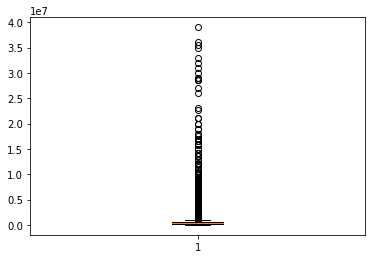

In [5]:
## Here I remove the outliers. After having tried a first option, that implied removing the 
## top 2.5% and bottom 2.5% based on price, I later opted for a second option, which instead
## implies only dropping the 5 most expensive and the 5 least expensive houses.
# train = train[(train["price"] >= train["price"].quantile(0.025)) & (train["price"] <= train["price"].quantile(0.975))]      
high_prices = train.nlargest(5, "price")   # I select the rows with the 5 highest prices
train = train.drop(high_prices.index)      # and I drop them
low_prices = train.nsmallest(5, "price")
train = train.drop(low_prices.index)
plt.boxplot(train["price"]);

In [6]:
## Here I handle null values, string values, and likely-to-be-wrong values

train["balcony"] = train["balcony"].replace({True: 1, np.nan: 0})   # replace the "True" with 1 and the nulls with 0
train["conditions"] = train["conditions"].replace({"Nuovo / Nuova costruzione" : 4,   # convert strings to numbers, in increasing order of quality     
                                                   "Ottimo / Ristrutturato" : 3,
                                                   "Buono stato / Abitabile" : 2,  
                                                   "Da ristrutturare" : 1})
median_conditions = np.median(train["conditions"].dropna())     
train["conditions"] = train["conditions"].replace({np.nan : median_conditions})    # replace the nulls with the median
train["construction_year"] = train["construction_year"].replace({np.nan : 1960})  # replace the nulls with 1960
train.loc[train["construction_year"]>2025, "construction_year"] = 1960   # replace the wrong years with 1960
train["latitude"] = train["latitude"].replace({np.nan : np.median(train["latitude"].dropna())})  # replace the nulls with the median
train["longitude"] = train["longitude"].replace({np.nan : np.median(train["longitude"].dropna())})  # replace the nulls with the median      
train["energy_efficiency"] = train["energy_efficiency"].replace({np.nan : np.mean(train["energy_efficiency"])})  # replace the nulls with the mean
train.loc[train["energy_efficiency"]>1e6, "energy_efficiency"] = np.mean(train["energy_efficiency"])  # replace the wrong enegy efficiencies with the mean       
train["expenses"] = train["expenses"].replace({np.nan : np.mean(train["expenses"])})    # replace the nulls with the mean
train["floor"] = train["floor"].replace({np.nan : np.median(train["floor"].dropna())})   # replace the nulls with the median
train.loc[train["floor"]>30, "floor"] = np.median(train["floor"].dropna())    # replace the (likely) wrong floors with the median
train["garden"] = train["garden"].replace({True : 1, np.nan : 0})   # replace the "True" with a 1, and the nulls with a 0
train["n_bathrooms"] = train["n_bathrooms"].replace({np.nan : np.median(train["n_bathrooms"].dropna())})  # replace the nulls with the median
train["elevator"] = train["elevator"].replace({np.nan : 0, True : 1, False : 0})  # replace the nulls and the "False" with 0, while the "True" with 1
train["total_floors"] = train["total_floors"].replace({np.nan : np.median(train["total_floors"].dropna())})   # replace the nulls with the median
train.loc[train["total_floors"]>25, "total_floors"] = np.median(train["total_floors"].dropna())   # replace the (likely) wrong total floors with the median  
train["n_rooms"] = train["n_rooms"].replace({np.nan : 3})   # replace the nulls with the median
train["proximity_to_center"] = train["proximity_to_center"].replace({np.nan : np.mean(train["proximity_to_center"])})   # replace the nulls with the mean   
train["surface"] = train["surface"].replace({np.nan : np.mean(train["surface"])})   # replace the nulls with the mean

In [7]:
## After noticing that some houses had a "floor" value greater than their "total_floors" value 
## (something impossible), I set the "total_floors" value of those houses equal to their "floor" value  
train.loc[train["floor"] > train["total_floors"], "total_floors"] = train.loc[train["floor"] > train["total_floors"], "floor"]      

# ADDING RELEVANT REGRESSORS

#### "city" and "dist_from_center"

In [8]:
## Here I add two regressors, namely "city" and "dist_from_center"
## For each point in the training dataset, I compute its Eucledian distance from each of the 
## centers of the three cities present in this dataset (Venice, Rome, and Milan). Then, based on the
## closest of the three, I assign to each house an integer from 1 to 3 indicating the city where 
## it is located, along with its actual distance from the city center.
## Note that 1 (the lowest number) corresponds to Venice (the city with the lowest average
## price in the dataset), while 3 (the greatest number) corresponds to Milan (the city with 
## the highest average price in the dataset).

venice_center = (45.4342, 12.3385)  # St. Marcus Square
rome_center = (41.8902, 12.4922)    # the Colosseum
milan_center = (45.4641, 9.1919)    # the Dome
cities_train = np.zeros(len(train))
dist_from_center_train = np.zeros(len(train))

for i in range(len(train)):
    lat, lon = train.iloc[i]["latitude"], train.iloc[i]["longitude"]
    dist_venice = ((venice_center[0]-lat)**2 + (venice_center[1]-lon)**2) ** 0.5
    dist_rome = ((rome_center[0]-lat)**2 + (rome_center[1]-lon)**2) ** 0.5
    dist_milan = ((milan_center[0]-lat)**2 + (milan_center[1]-lon)**2) ** 0.5
    cities_train[i] = np.argmin([dist_venice, dist_rome, dist_milan])+1   # so 1:Venice, 2:Rome, 3:Milan     
    dist_from_center_train[i] = min([dist_venice, dist_rome, dist_milan])

## Now I actually add the two regressors to the dataset
train["city"] = cities_train
train["dist_from_center"] = dist_from_center_train

#### "avg_price_per_location"

In [9]:
## Here I split the training data into three different sets, one per city
train_venice = train.loc[train["city"]==1]
train_rome = train.loc[train["city"]==2]
train_milan = train.loc[train["city"]==3]

In [10]:
## Here I define a function for deciding a good value for k (which is the number of clusters) for 
## each of the three cities. The function trains various k-means models, each with a different k
## from k_min (included) to k_max (excluded), for each kmean it computes the within-cluster sum
## of squares, and then it plots this value as a function of k.
## For each city, I chose a value of k such that increasing k by 1 would lead only to a negligible
## decrease in the cost.

def elbow_method(df, k_min, k_max, city, seed=None):
    lat_lon = df[["latitude", "longitude"]]
    wcss = []     # this stands for within-cluster sum of squares
    for k in range(k_min, k_max):  # For each value of k I fit a k-means model, and I save its wcss      
        kmeans = KMeans(n_clusters=k, random_state=seed)
        kmeans.fit(lat_lon)
        wcss.append(kmeans.inertia_)
    ## I plot the wcss as a function of k
    plt.plot(range(k_min, k_max), wcss)
    plt.xlabel("Number of Clusters")
    plt.ylabel("WCSS")
    plt.title(f"Elbow Method for {city}")
    plt.show()

In [11]:
## Here I define a function that actually plots the different neighbourhoods, each with a 
## different color

def plot_clusters(df, k, seed, city):
    kmeans = KMeans(n_clusters=k, random_state=seed)
    kmeans.fit(df[["latitude", "longitude"]])
    cluster_labels = kmeans.labels_
    plt.scatter(df["longitude"], df["latitude"], c=cluster_labels, cmap="viridis")       
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.title(f"{city} neighbourhoods")
    plt.show()

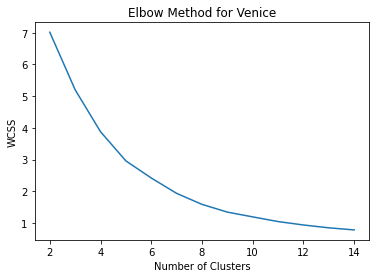

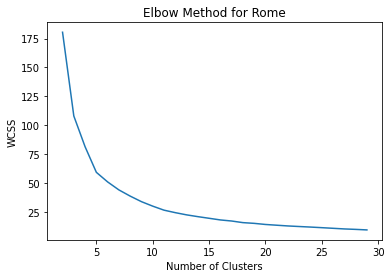

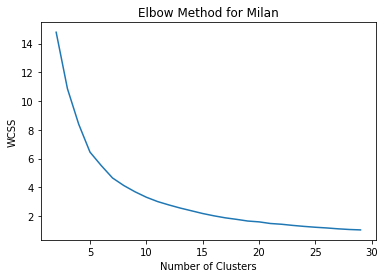

In [12]:
## Based on the outputs of these three functions, I set the value of k for each of the three cities
elbow_method(train_venice, 2, 15, "Venice", 1)  # for Venice I set k = 7
elbow_method(train_rome, 2, 30, "Rome", 1)      # for Rome I set k = 12
elbow_method(train_milan, 2, 30, "Milan", 1)    # for Milan I set k = 11

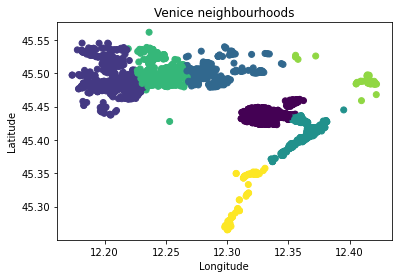

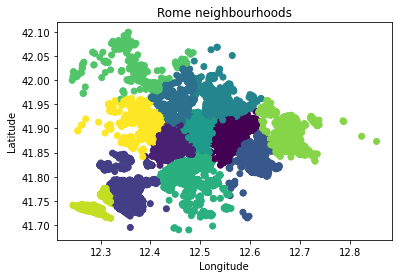

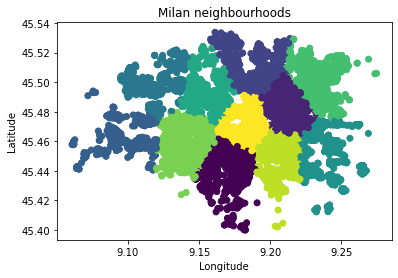

In [13]:
## Here I visualize the neighbourhoods to make sure they make sense, geographically speaking
plot_clusters(train_venice, 7, 1, "Venice")
plot_clusters(train_rome, 12, 1, "Rome")
plot_clusters(train_milan, 11, 1, "Milan")

In [14]:
## Here I actually perform the clustering, and I associate to each house an integer, representing
## the neighbourhood it belongs to

kmeans_venice = KMeans(n_clusters=7, random_state=1)   # I previously chose k = 7
kmeans_rome = KMeans(n_clusters=12, random_state=1)    # I previously chose k = 12
kmeans_milan = KMeans(n_clusters=11, random_state=1)   # I previously chose k = 11

kmeans_venice.fit(train_venice[["latitude", "longitude"]])
kmeans_rome.fit(train_rome[["latitude", "longitude"]])
kmeans_milan.fit(train_milan[["latitude", "longitude"]])

labels_venice = kmeans_venice.labels_
labels_rome = kmeans_rome.labels_ + 100     # the +100 and +1000 are just to make sure each 
labels_milan = kmeans_milan.labels_ + 1000  # location has a unique label

## Here I actually add the new regressor
train_venice.loc[:, "location"] = labels_venice 
train_rome.loc[:, "location"] = labels_rome
train_milan.loc[:, "location"] = labels_milan

In [15]:
## Now I put the three datasets back together, and I make sure that the original order 
## is not altered 

train_all = pd.concat([train_venice, train_rome, train_milan], axis=0)
cat_type = pd.CategoricalDtype(categories=train["id"], ordered=True)

train_all["id_cat"] = train_all["id"].astype(cat_type)
train = train_all.sort_values("id_cat")
train.drop(columns=["id_cat"], inplace=True)  # I drop the temporary "id_cat" column

In [16]:
## Here I create a dictionary in which the keys are the neighbourhoods labels, and the values are
## the average price per square meter in that neighbourhood, based on the training data

avg_price_per_location = {
    ## Venice
    0 : np.sum(np.array(train["price"].loc[train["location"]==0])) / np.sum(np.array(train["surface"].loc[train["location"]==0])),
    1 : np.sum(np.array(train["price"].loc[train["location"]==1])) / np.sum(np.array(train["surface"].loc[train["location"]==1])),         
    2 : np.sum(np.array(train["price"].loc[train["location"]==2])) / np.sum(np.array(train["surface"].loc[train["location"]==2])),
    3 : np.sum(np.array(train["price"].loc[train["location"]==3])) / np.sum(np.array(train["surface"].loc[train["location"]==3])),
    4 : np.sum(np.array(train["price"].loc[train["location"]==4])) / np.sum(np.array(train["surface"].loc[train["location"]==4])),
    5 : np.sum(np.array(train["price"].loc[train["location"]==5])) / np.sum(np.array(train["surface"].loc[train["location"]==5])),
    6 : np.sum(np.array(train["price"].loc[train["location"]==6])) / np.sum(np.array(train["surface"].loc[train["location"]==6])),
    ## Rome
    100 : np.sum(np.array(train["price"].loc[train["location"]==100])) / np.sum(np.array(train["surface"].loc[train["location"]==100])),
    101 : np.sum(np.array(train["price"].loc[train["location"]==101])) / np.sum(np.array(train["surface"].loc[train["location"]==101])),
    102 : np.sum(np.array(train["price"].loc[train["location"]==102])) / np.sum(np.array(train["surface"].loc[train["location"]==102])),
    103 : np.sum(np.array(train["price"].loc[train["location"]==103])) / np.sum(np.array(train["surface"].loc[train["location"]==103])),
    104 : np.sum(np.array(train["price"].loc[train["location"]==104])) / np.sum(np.array(train["surface"].loc[train["location"]==104])),
    105 : np.sum(np.array(train["price"].loc[train["location"]==105])) / np.sum(np.array(train["surface"].loc[train["location"]==105])),
    106 : np.sum(np.array(train["price"].loc[train["location"]==106])) / np.sum(np.array(train["surface"].loc[train["location"]==106])),
    107 : np.sum(np.array(train["price"].loc[train["location"]==107])) / np.sum(np.array(train["surface"].loc[train["location"]==107])),
    108 : np.sum(np.array(train["price"].loc[train["location"]==108])) / np.sum(np.array(train["surface"].loc[train["location"]==108])),
    109 : np.sum(np.array(train["price"].loc[train["location"]==109])) / np.sum(np.array(train["surface"].loc[train["location"]==109])),         
    110 : np.sum(np.array(train["price"].loc[train["location"]==110])) / np.sum(np.array(train["surface"].loc[train["location"]==110])),
    111 : np.sum(np.array(train["price"].loc[train["location"]==111])) / np.sum(np.array(train["surface"].loc[train["location"]==111])),
    ## Milan
    1000 : np.sum(np.array(train["price"].loc[train["location"]==1000])) / np.sum(np.array(train["surface"].loc[train["location"]==1000])),
    1001 : np.sum(np.array(train["price"].loc[train["location"]==1001])) / np.sum(np.array(train["surface"].loc[train["location"]==1001])),
    1002 : np.sum(np.array(train["price"].loc[train["location"]==1002])) / np.sum(np.array(train["surface"].loc[train["location"]==1002])),
    1003 : np.sum(np.array(train["price"].loc[train["location"]==1003])) / np.sum(np.array(train["surface"].loc[train["location"]==1003])),
    1004 : np.sum(np.array(train["price"].loc[train["location"]==1004])) / np.sum(np.array(train["surface"].loc[train["location"]==1004])),
    1005 : np.sum(np.array(train["price"].loc[train["location"]==1005])) / np.sum(np.array(train["surface"].loc[train["location"]==1005])),
    1006 : np.sum(np.array(train["price"].loc[train["location"]==1006])) / np.sum(np.array(train["surface"].loc[train["location"]==1006])),
    1007 : np.sum(np.array(train["price"].loc[train["location"]==1007])) / np.sum(np.array(train["surface"].loc[train["location"]==1007])),
    1008 : np.sum(np.array(train["price"].loc[train["location"]==1008])) / np.sum(np.array(train["surface"].loc[train["location"]==1008])),
    1009 : np.sum(np.array(train["price"].loc[train["location"]==1009])) / np.sum(np.array(train["surface"].loc[train["location"]==1009])),
    1010 : np.sum(np.array(train["price"].loc[train["location"]==1010])) / np.sum(np.array(train["surface"].loc[train["location"]==1010]))       
                         }

In [17]:
## Here I create a new regressor, which is the average price per square meter in each of the 30 
## neighbourhoods I identified before, and I add it to the training set. 
## I also remove the "location" column, as it is now redundant.

avg_price_per_sm_train = np.zeros(len(train))
for i in range(len(train)):
    avg_price_per_sm_train[i] = avg_price_per_location[train.iloc[i]["location"]]
train["avg_price_per_location"] = avg_price_per_sm_train
train.drop(["location"], axis=1, inplace=True)

##### Now I try to extract some relevant information from the "poi.csv" dataset

In [18]:
## First I load the dataset
poi = pd.read_csv("/Users/Giulio/Library/Mobile Documents/com~apple~CloudDocs/Bocconi/Second Year/Second Semester/ Machine Learning/Challenge/poi.csv")   

In [19]:
## I only consider the points of interest that have been classified according to one of the 
## 173 categories of amenities (roughly 50 000 observations)
poi.dropna(subset=["tags.amenity"], inplace=True)

In [20]:
## Now I use the poi dataset to compute, for each house in the "train" dataset, the number of
## points of interest within a radius of 1 kilometer from the house

poi_lat = np.array(poi["lat"])
poi_lon = np.array(poi["lon"])

closeby_poi_train = np.zeros(len(train))
for i in range(len(train)):
    lat, lon = train.iloc[i]["latitude"], train.iloc[i]["longitude"]
    dist_train = np.sqrt((lat - poi_lat)**2 + (lon - poi_lon)**2)    
    closeby_poi_train[i] = np.sum(dist_train<0.00951)  # this computes the number of points of interest at distance < 1km from each house          
train["closeby_poi"] = closeby_poi_train

# CHECKING FOR IRRELEVANT REGRESSORS

In [21]:
## Here I display the correlation between the dependent variable ("price"), and all the regressors.
## The features with a low correlation with "price" are "balcony", "conditions", "enegy_efficiency", 
## "expenses", "garden", "elevator", and "total_floors". 
## I don't drop these regressors from my dataset just yet, first of all because correlation with 
## the dependent variable is only one of the many ways in which we can assess the relevance of 
## a feature, and also because it only measures the linear relationship between any two variables 
## (meaning that if a regressor has a very strong influence on the output, but this influence is 
## not linear, it might still have a relatively-low correlation with "price").
## Also, notice that all the regressors I added myself are relatively correlated with "price", 
## and this is a good sign.

train.corr()["price"] * 100

id                         -0.058221
price                     100.000000
balcony                     0.004153
conditions                  1.413154
construction_year         -10.296690
latitude                    4.777732
longitude                  -7.014116
energy_efficiency           2.560450
expenses                    0.652547
floor                       3.150250
garden                     -1.196738
n_bathrooms                19.515186
elevator                    0.865975
total_floors                0.973546
n_rooms                    21.813084
proximity_to_center         3.580766
surface                    42.426768
city                        6.259713
dist_from_center          -17.889724
avg_price_per_location     26.005342
closeby_poi                23.423746
Name: price, dtype: float64

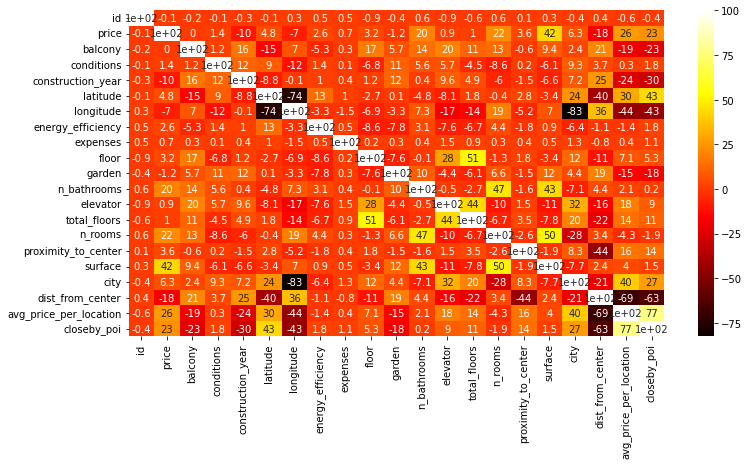

In [22]:
## By plotting the correlation matrix of my training dataset, I can assess that, although there are
## some related features, I only remove "proximity_to_center" (that is likely to capture much of the
## factos already captured by "dist_from_center", which is a more precise regressor).

plt.figure(figsize=(12,6))
sns.heatmap(np.round(train.corr()*100,1), annot=True, cmap="hot");
train.drop(["proximity_to_center"], axis=1, inplace=True) 

# BUILDING A MODEL
#### Now it's time to actually develop a model.
#### After having experimented with a linear regression, a neural network, and a random forest, I opted for the latter, as it proved to perform significantly better than the other two in this context.
#### Anyway, for completeness, I have left two Raw NBConvert cells, one for training a linear regression, and the other one for a neural network.

### Now I develop my model of choice: a random forest

In [23]:
## This cell splits my training data into a training set and a testing set. It serves the aim of 
## testing the effectiveness of the model before submitting a prediction on Kaggle. It is also 
## useful to set the number of estimators of the random forest, as well as to decide which 
## regressors to drop (based on the output of this cell, I removed "expenses" and 
## "energy_efficiency", out of the possible variables to drop I identified above, when studying 
## the correlation of the regressors with "price").

rf_X_train_temp, rf_X_test_temp, rf_y_train_temp, rf_y_test_temp = train_test_split(train.drop(["price", "id"], axis=1), train["price"], test_size=0.2, random_state=1)     
rf_temporary = RandomForestRegressor(n_estimators=300, random_state=1)
rf_temporary.fit(rf_X_train_temp, rf_y_train_temp)

# Here I evaluate the model on the testing set 
score = rf_temporary.score(rf_X_test_temp, rf_y_test_temp)
mse = mean_squared_error(rf_y_test_temp, rf_temporary.predict(rf_X_test_temp))
print(f"R^2 Score: {score:.4f}")
print(f"Mean Squared Error: {mse:.4f}")

R^2 Score: 0.4885
Mean Squared Error: 432570385914.9426


In [24]:
train.drop(["expenses", "energy_efficiency"], axis=1, inplace=True)

In [25]:
## Now that I have identified which model to use, as well as which regressors to keep, I can 
## train the model I will later use to make predictions

rf_X_train, rf_y_train = train.drop(["price", "id"], axis=1), train["price"]       
rf = RandomForestRegressor(n_estimators=300)
rf.fit(rf_X_train, rf_y_train)

RandomForestRegressor(n_estimators=300)

# MODIFYING THE TEST DATASET
### The vast majority of what follows is just a repetition of the things I did above, but this time applied to the test dataframe

In [26]:
## I import the set of data for which I have to predict the price
test = pd.read_csv("/Users/Giulio/Library/Mobile Documents/com~apple~CloudDocs/Bocconi/Second Year/Second Semester/ Machine Learning/Challenge/test.csv")    

In [27]:
## Here I handle string values, null values, and likely-to-be-wrong values in the same way I did 
## above, when cleaning up the train dataset

test.drop(["energy_efficiency", "expenses", "proximity_to_center"], axis=1, inplace=True)
test_id = test["id"]
test["balcony"] = test["balcony"].replace({True: 1, np.nan: 0})
test["conditions"] = test["conditions"].replace({"Nuovo / Nuova costruzione" : 4,
                                                 "Ottimo / Ristrutturato": 3,
                                                 "Buono stato / Abitabile": 2,  
                                                 "Da ristrutturare" : 1,
                                                 np.nan : median_conditions})
test["construction_year"] = test["construction_year"].replace({np.nan : 1960})
test.loc[test["construction_year"]>2025, "construction_year"] = 1960
test["latitude"] = test["latitude"].replace({np.nan : np.median(train["latitude"].dropna())})
test["longitude"] = test["longitude"].replace({np.nan : np.median(train["longitude"].dropna())})
test["floor"] = test["floor"].replace({np.nan : np.median(train["floor"].dropna())})
test.loc[test["floor"]>25, "floor"] = np.median(train["floor"].dropna())
test["garden"] = test["garden"].replace({True : 1, np.nan : 0})
test["n_bathrooms"] = test["n_bathrooms"].replace({np.nan : np.median(train["n_bathrooms"].dropna())})
test["elevator"] = test["elevator"].replace({np.nan : 0, True : 1, False : 0})
test["total_floors"] = test["total_floors"].replace({np.nan : np.median(train["total_floors"])})
test["n_rooms"] = test["n_rooms"].replace({np.nan : 3})     
test["surface"] = test["surface"].replace({np.nan : np.mean(train["surface"])})   

In [28]:
## As I did above, here I also take care of the observations whose "floor" value is greater than 
## the "total_floors" one
test.loc[test["floor"] > test["total_floors"], "total_floors"] = test.loc[test["floor"] > test["total_floors"], "floor"]    

In [29]:
## Here I add the "city" and "dist_from_center" regressors, as already discussed above

cities_test = np.zeros(len(test))
dist_from_center_test = np.zeros(len(test))
for i in range(len(test)):
    lat, lon = test.iloc[i]["latitude"], test.iloc[i]["longitude"]
    dist_venice = ((venice_center[0]-lat)**2 + (venice_center[1]-lon)**2) ** 0.5
    dist_rome = ((rome_center[0]-lat)**2 + (rome_center[1]-lon)**2) ** 0.5
    dist_milan = ((milan_center[0]-lat)**2 + (milan_center[1]-lon)**2) ** 0.5
    cities_test[i] = np.argmin([dist_venice, dist_rome, dist_milan])+1   # so 1:Venice, 2:Rome, 3:Milan     
    dist_from_center_test[i] = min([dist_venice, dist_rome, dist_milan])
    
test["city"] = cities_test
test["dist_from_center"] = dist_from_center_test

In [30]:
## Now I add the "avg_price_per_location" variable. The way I do this in the test set is 
## different than how I did for the training set, because now I have to make sure that each 
## i^th cluster in the training set actually corresponds to the i^th cluster of the test set.
## So, I find the latitude ad longitude of the 30 centroids computed above, and then for each 
## house in the "test" dataset I compute its distance from each of the 30 centroids. I then 
## assign to it the value of the neighbourhood based on the centroid closest to it. 
## Then I assign to each test datapoint the value of "avg_price_per_location" (which is the 
## average price per square meter) based on which neighbourhood it is located in, and using the
## dictionary "avg_price_per_location", which I created above.

centroids_lat = np.array([x[0] for x in kmeans_venice.cluster_centers_] + [x[0] for x in kmeans_rome.cluster_centers_] + [x[0] for x in kmeans_milan.cluster_centers_])       
centroids_lon = np.array([x[1] for x in kmeans_venice.cluster_centers_] + [x[1] for x in kmeans_rome.cluster_centers_] + [x[1] for x in kmeans_milan.cluster_centers_])       
labels = [0,1,2,3,4,5,6,100,101,102,103,104,105,106,107,108,109,110,111,1000,1001,1002,1003,1004,1005,1006,1007,1008,1009,1010]
d = {i:labels[i] for i in range(len(labels))}  # this dictionary will allow me to set the right "location" values   

location_test = np.zeros(len(test))
for i in range(len(test)):
    lat, lon = test.iloc[i]["latitude"], test.iloc[i]["longitude"]
    dist_from_centroids = np.sqrt((lat-centroids_lat)**2 + (lon-centroids_lon)**2)
    location_test[i] = d[np.argmin(dist_from_centroids)]  # this makes sure that the cluster label is correct     
test["location"] = location_test

avg_price_per_sm_test = np.zeros(len(test))
for i in range(len(test)):
    avg_price_per_sm_test[i] = avg_price_per_location[test.iloc[i]["location"]]  # I use the dictionary created for the training set      
test["avg_price_per_location"] = avg_price_per_sm_test
test.drop(["location"], axis=1, inplace=True)   # this variable is now redundant, so I drop it (just like I did for the training set)       

In [31]:
## Just as I did for the training set, I compute, for each house in the test dataset, the number 
## of points of interest within a radius of 1 kilometer from the observation

closeby_poi_test = np.zeros(len(test))
for i in range(len(test)):
    lat, lon = test.iloc[i]["latitude"], train.iloc[i]["longitude"]
    dist_test = np.sqrt((lat - poi_lat)**2 + (lon - poi_lon)**2)    
    closeby_poi_test[i] = np.sum(dist_test<0.00951)  # this computes the number of points of interest at distance < 1km from each house          
test["closeby_poi"] = closeby_poi_test

# MAKING PREDICTIONS

In [32]:
predictions_final = pd.DataFrame(test["id"])
predictions_final["price"] = rf.predict(test.drop(["id"], axis=1))
predictions_final.to_csv("Predictions_final.csv", index=False)